In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from urllib.parse import quote, unquote
from bs4 import BeautifulSoup

In [2]:
articles = pd.read_csv('wikispeedia_paths-and-graph/articles.tsv', comment='#', delimiter='\t', encoding='utf8', 
                                    names=['article'])
categories = pd.read_csv('wikispeedia_paths-and-graph/categories.tsv', comment='#', delimiter='\t',
                                    names=['article', 'category'])
links = pd.read_csv('wikispeedia_paths-and-graph/links.tsv', comment='#', delimiter='\t', 
                                    names=['article', 'linkTarget'])  
finished_paths = pd.read_csv('wikispeedia_paths-and-graph/paths_finished.tsv', comment='#', delimiter='\t', 
                                    names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
unfinished_paths = pd.read_csv('wikispeedia_paths-and-graph/paths_unfinished.tsv', comment='#', delimiter='\t',
                                    names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])

In [3]:
# Apply decoding on articles
# Note: article names stored in df are decdoed but with 
# underscores (_) instead of spaces ( )
articles['article'] = articles['article'].apply(unquote)
categories['article'] = categories['article'].apply(unquote)
links = links.applymap(unquote)
links.head(5)

,article,linkTarget
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland


In [11]:
links22 = pd.read_csv('Wiki_2022/links22.tsv', comment='#', delimiter='\t', names=['article', 'linkTarget']).applymap(unquote)
links22.head()

,article,linkTarget
0,linkSource,linkTarget
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Isle_of_Man
3,Áedán_mac_Gabráin,Genealogy
4,Áedán_mac_Gabráin,Bede


In [4]:
# Set indices
articles.set_index('article', inplace=True)
categories.set_index('article', inplace=True)
finished_paths.set_index('hashedIpAddress', inplace=True)
unfinished_paths.set_index('hashedIpAddress', inplace=True)

In [5]:
# Create df with all paths
paths_combined = pd.concat([finished_paths, unfinished_paths])
paths_combined.head(5)
print(len(finished_paths.index))

51318


In [6]:
# Filter out all paths with <
finished_paths_with_back = finished_paths.loc[finished_paths.path.str.contains('<')]

def get_associated_articles(path):
    article_list = path.split(';')
    index = article_list.index('<')
    return article_list[index-1], article_list[index+1]
    
# Add columns of associated articles before and after <
# TODO: get rid of warnings
finished_paths_with_back['article1'], finished_paths_with_back['article2'] = \
    zip(*finished_paths_with_back['path'].map(get_associated_articles))
finished_paths_with_back.head(5)

/var/folders/gg/nvlghfjs75g8s2cktfy2rbd40000gn/T/ipykernel_12578/3853467544.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finished_paths_with_back['article1'], finished_paths_with_back['article2'] = \
/var/folders/gg/nvlghfjs75g8s2cktfy2rbd40000gn/T/ipykernel_12578/3853467544.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finished_paths_with_back['article1'], finished_paths_with_back['article2'] = \


,timestamp,durationInSec,path,rating,article1,article2
hashedIpAddress,,,,,,
4cb0068c36658716,1248654953,253,14th_century;Time;Science;Nature;Weather;Sunli...,3.0,Sunlight,Sun
0d57c8c57d75e2f5,1283956474,391,14th_century;Renaissance;Empiricism;Nature;Wea...,5.0,Sunlight,Rain
0d57c8c57d75e2f5,1290753904,432,14th_century;Renaissance;Leonardo_da_Vinci;Wat...,NaN,Cloud,<
03dc907932cecfc5,1336436263,387,14th_century;Europe;Republic_of_Ireland;<;<;Eu...,2.0,Republic_of_Ireland,<
46021cc81bd7069a,1343940479,246,14th_century;Time;Physics;<;Day;Sun;Sunlight;U...,NaN,Physics,Day


In [7]:
len(finished_paths_with_back.index)

8995

In [8]:
# Functions for accessing article data
# Return a list containing plaintext content of wikipedia article
def get_plaintext(name):
    file_path = 'plaintext_articles/' + quote(name) + '.txt'
    with open(file_path, encoding='utf-8') as file:
        #first 5 lines are comments and titles 
        lines = file.readlines()[5:] 
        return list(map(str.strip, lines))

# Return prettified html content of wikipedia article
def get_html(name):
    file_path = 'wpcd/wp/' + name[0] + '/' + quote(name) + '.htm'
    with open(file_path) as file:
        html_doc = file.read()
        soup = BeautifulSoup(html_doc, 'html.parser')
        return soup.prettify()

## Exploratory Data Analysis

In [13]:
# Exploratory Data Analysis
n_articles = len(articles)
print(f'The number of articles is: {n_articles}')


The number of articles is: 4604


### Wikispeedia Graph Structure
Stats and visualisations of the graph structure of the original Wikispeedia dataset

The mean number of inlinks is: 26.04
The maximum number of inlinks on any page is: 1551.0. This is the article on United_States.
The number of pages without any inlinks is: 469


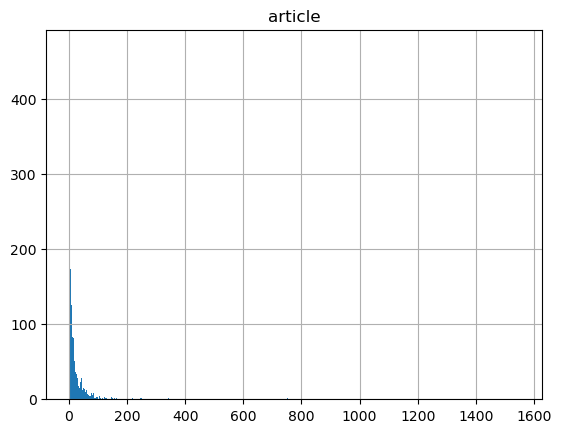

In [67]:
incoming = links.groupby(['linkTarget'])['article'].count()
articles_incoming = (articles.join(incoming).fillna(0))

articles_incoming_lt = articles_incoming.article
mean_links = articles_incoming_lt.mean()
max_links = articles_incoming_lt.max()
num_leaves = (articles_incoming_lt == 0).sum()
print(f'The mean number of inlinks is: {mean_links:.2f}')
print(f'The maximum number of inlinks on any page is: {max_links}. This is the article on {articles_incoming_lt[articles_incoming_lt==max_links].index[0]}.')
print(f'The number of pages without any inlinks is: {num_leaves}')

articles_incoming_lt
bins = [i for i in range(int(max(articles_incoming_lt)+1))]
ax = articles_incoming.hist(bins=bins)
plt.show()

The mean number of links is: 26.04
The maximum number of outlinks on any page is: 294.0. This is the article on United_States.
The number of pages without any outlinks is: 17


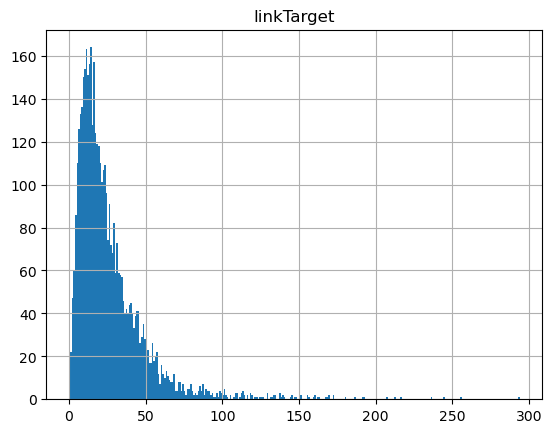

In [64]:
outgoing = links.groupby(['article'])['linkTarget'].count()
articles_outgoing = (articles.join(outgoing).fillna(0))

articles_outgoing_lt = articles_outgoing.linkTarget
mean_links = articles_outgoing_lt.mean()
max_links = articles_outgoing_lt.max()
num_leaves = (articles_outgoing_lt == 0).sum()
print(f'The mean number of outlinks is: {mean_links:.2f}')
print(f'The maximum number of outlinks on any page is: {max_links}. This is the article on {articles_outgoing_lt[articles_outgoing_lt==max_links].index[0]}.')
print(f'The number of pages without any outlinks is: {num_leaves}')

articles_outgoing_lt
bins = [i for i in range(int(max(articles_outgoing_lt)+1))]
ax = articles_outgoing.hist(bins=bins)
plt.show()

### Wikipedia Graph Structure 2022
Stats and visualisations of the graph structure of current wikipedia using the same nodes as in the Wikispeedia dataset

The mean number of inlinks in 2022 is: 49.43
The maximum number of inlinks in 2022 on any page is: 1064.0. This is the article on United_States.
The number of pages without any inlinks in 2022 is: 467


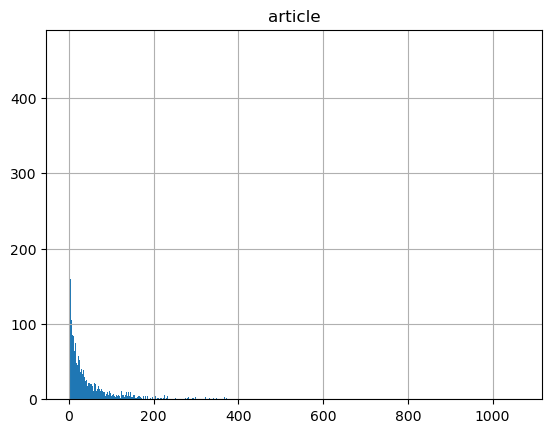

In [71]:
incoming22 = links22.groupby(['linkTarget'])['article'].count()
articles_incoming22 = (articles.join(incoming22).fillna(0))

articles_incoming22_lt = articles_incoming22.article
mean_links22 = articles_incoming22_lt.mean()
max_links22 = articles_incoming22_lt.max()
num_leaves = (articles_incoming22_lt == 0).sum()
print(f'The mean number of inlinks in 2022 is: {mean_links22:.2f}')
print(f'The maximum number of inlinks in 2022 on any page is: {max_links22}. This is the article on {articles_incoming22_lt[articles_incoming22_lt==max_links22].index[0]}.')
print(f'The number of pages without any inlinks in 2022 is: {num_leaves}')

articles_incoming22_lt
bins = [i for i in range(int(max(articles_incoming22_lt)+1))]
ax = articles_incoming22.hist(bins=bins)
plt.show()

The mean number of outlinks in 2022 is: 49.43
The maximum number of outlinks in 2022 on any page is: 367.0. This is the article on Europe.
The number of pages without any outlinks in 2022 is: 11


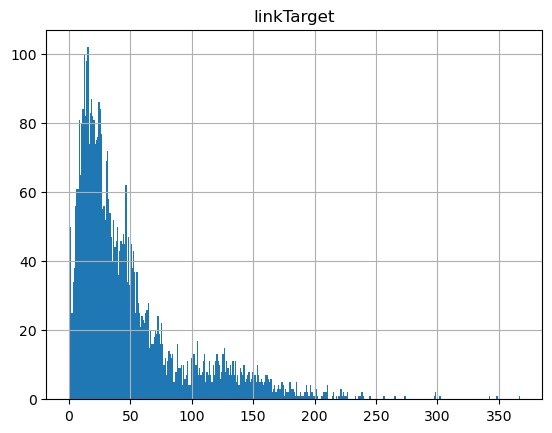

In [74]:
outgoing22 = links22.groupby(['article'])['linkTarget'].count()
articles_outgoing22 = (articles.join(outgoing22).fillna(0))

articles_outgoing22_lt = articles_outgoing22.linkTarget
mean_links22 = articles_outgoing22_lt.mean()
max_links22 = articles_outgoing22_lt.max()
num_leaves = (articles_outgoing22_lt == 0).sum()
print(f'The mean number of outlinks in 2022 is: {mean_links22:.2f}')
print(f'The maximum number of outlinks in 2022 on any page is: {max_links22}. This is the article on {articles_outgoing22_lt[articles_outgoing22_lt==max_links22].index[0]}.')
print(f'The number of pages without any outlinks in 2022 is: {num_leaves}')

articles_outgoing22_lt
bins = [i for i in range(int(max(articles_outgoing22_lt)+1))]
ax = articles_outgoing22.hist(bins=bins)
plt.show()


We can see that the number of links has nearly doubled